# NFL Big Data Bowl 2022 Notebook
### Author: Conrad Bituin

## Topic to Analyze

Quantify special teams strategy. Special teams’ coaches are among the most creative and innovative in the league. Compare/contrast how each team game plans. Which strategies yield the best results? What are other strategies that could be adopted?


### References
- [Official Competition Page](https://www.kaggle.com/c/nfl-big-data-bowl-2022/overview)
- [Official Explanation of Data](https://www.kaggle.com/c/nfl-big-data-bowl-2022/data)
- [Beginner Notebook via Kaggle](https://www.kaggle.com/werooring/nfl-big-data-bowl-basic-eda-for-beginner/notebook)
- [Previous Bowl Recaps](https://operations.nfl.com/gameday/analytics/big-data-bowl/past-big-data-bowl-recaps/)

## Background

As of the writing of this notebook (Week 14, 2021 Season), NFL kickers have collectively missed 69 extra point attempts (PATs) and 122 field goals in the 2021 season [according to Pro Football Reference](https://www.pro-football-reference.com/). The intent of this notebook is to analyze the various situations and scenarios that could affect PAT and field goal outcomes. The model produced will attempt to find the optimal field conditions that will produce the highest likelihood for successful extra point and field goal attempts.

## Acquire Data

In [1]:
# Common imports

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import pandas as pd

In [2]:
# File imports

# The games.csv contains the teams playing in each game. The key variable is gameId.
games_df = pd.read_csv('../data/games.csv')

# The PFFScoutingData.csv file contains play-level scouting information for each game. The key variables are gameId and playId.
pffscouting_df = pd.read_csv('../data/PFFScoutingData.csv')

# The players.csv file contains player-level information from players that participated in any of the tracking data files. The key variable is nflId.
players_df = pd.read_csv('../data/players.csv')

# The plays.csv file contains play-level information from each game. The key variables are gameId and playId.
plays_df = pd.read_csv('../data/plays.csv')

#Files tracking[season].csv contain player tracking data from season [season]. The key variables are gameId, playId, and nflId.
tracking_2018_df = pd.read_csv('../data/tracking2018.csv')
tracking_2019_df = pd.read_csv('../data/tracking2019.csv')
tracking_2020_df = pd.read_csv('../data/tracking2020.csv')

## Analyze and Describe Data

### Summary 

Based on the data provided for consideration, there are a total of:
- 764 games
- 2732 players
- 4435 plays
  - 1986 plays were Field Goal attempts
  - 2345 plays were Extra Point attempts 


### Overview of Games, Plays, and Players

In [3]:
print('Dataframe: Games')
games_df.head()

Dataframe: Games


gameId  season  week    gameDate gameTimeEastern homeTeamAbbr  \
0  2018090600    2018     1  09/06/2018        20:20:00          PHI   
1  2018090900    2018     1  09/09/2018        13:00:00          BAL   
2  2018090901    2018     1  09/09/2018        13:00:00          CLE   
3  2018090902    2018     1  09/09/2018        13:00:00          IND   
4  2018090903    2018     1  09/09/2018        13:00:00          MIA   

  visitorTeamAbbr  
0             ATL  
1             BUF  
2             PIT  
3             CIN  
4             TEN

In [4]:
print('Dataframe: Players')
players_df.head()

Dataframe: Players


nflId height  weight   birthDate       collegeName Position  \
0  42901    6-1     208  1992-07-25     James Madison       SS   
1  43501    6-0     220  1994-08-11  Central Michigan       FS   
2  43534    6-0     205  1993-06-02          Illinois       SS   
3  43535    6-1     235  1992-12-22            Temple      MLB   
4  44174    6-1     236  1993-02-22        Texas Tech      ILB   

         displayName  
0       Dean Marlowe  
1      Kavon Frazier  
2  Clayton Fejedelem  
3   Tyler Matakevich  
4       Sam Eguavoen

In [5]:
print('Dataframe: Plays')
plays_df.head()

Dataframe: Plays


gameId  playId                                    playDescription  \
0  2018090600      37  J.Elliott kicks 65 yards from PHI 35 to end zo...   
1  2018090600     366  (9:20) C.Johnston punts 56 yards to ATL 36, Ce...   
2  2018090600     658  (5:03) M.Bryant 21 yard field goal is GOOD, Ce...   
3  2018090600     677  M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...   
4  2018090600     872  (:33) C.Johnston punts 65 yards to end zone, C...   

   quarter  down  yardsToGo possessionTeam specialTeamsPlayType  \
0        1     0          0            PHI              Kickoff   
1        1     4          4            PHI                 Punt   
2        1     4          3            ATL           Field Goal   
3        1     0          0            ATL              Kickoff   
4        1     4         18            PHI                 Punt   

  specialTeamsResult  kickerId  ... penaltyCodes  penaltyJerseyNumbers  \
0          Touchback   44966.0  ...          NaN                   NaN   
1             Return   45603.0  ...         UNSd                PHI 18   
2  Kick Attempt Good   27091.0  ...          NaN                   NaN   
3             Return   37267.0  ...          NaN                   NaN   
4          Touchback   45603.0  ...          NaN                   NaN   

  penaltyYards  preSnapHomeScore preSnapVisitorScore passResult kickLength  \
0          NaN                 0                   0        NaN       66.0   
1        -15.0                 0                   0        NaN       56.0   
2          NaN                 0                   0        NaN       21.0   
3          NaN                 0                   3        NaN       64.0   
4          NaN                 0                   3        NaN       65.0   

   kickReturnYardage  playResult  absoluteYardlineNumber  
0                NaN          40                      45  
1                5.0          36                      18  
2                NaN           0                      13  
3               30.0          34                      75  
4                NaN          45                      45  

[5 rows x 25 columns]

### Creating Test Sets

In [6]:
from sklearn.model_selection import train_test_split

fg_df = plays_df[plays_df.specialTeamsPlayType == 'Field Goal']
pat_df = plays_df[plays_df.specialTeamsPlayType == 'Extra Point']

fg_train, fg_test = train_test_split(fg_df, test_size=0.2, random_state=42)

pat_train, pat_test = train_test_split(pat_df, test_size=0.2, random_state=42)

In [7]:
# Preparing Data for Visualization
%matplotlib inline

# Field Goal Plays
fg_df_by_quarter = fg_train.groupby('quarter').nunique().reset_index()[['quarter','playId']]
fg_df_by_down = fg_train.groupby('down').nunique().reset_index()[['down','playId']]

fg_success_by_kicker = fg_train[fg_train.specialTeamsResult == 'Kick Attempt Good'].groupby('kickerId').nunique().reset_index()[['kickerId','playId']]
fg_total_by_kicker = fg_train.groupby('kickerId').nunique().reset_index()[['kickerId','playId']]

fg_success_by_team = fg_train[fg_train.specialTeamsResult == 'Kick Attempt Good'].groupby('possessionTeam').nunique().reset_index()[['possessionTeam','playId']]
fg_total_by_team = fg_train.groupby('possessionTeam').nunique().reset_index()[['possessionTeam','playId']]

# PAT Plays
pat_df_by_quarter = pat_train.groupby('quarter').nunique().reset_index()[['quarter','playId']]
pat_df_by_down = pat_train.groupby('down').nunique().reset_index()[['down','playId']]

pat_success_by_kicker = pat_train[pat_train.specialTeamsResult == 'Kick Attempt Good'].groupby('kickerId').nunique().reset_index()[['kickerId','playId']]
pat_total_by_kicker = pat_train.groupby('kickerId').nunique().reset_index()[['kickerId','playId']]

pat_success_by_team = pat_train[pat_train.specialTeamsResult == 'Kick Attempt Good'].groupby('possessionTeam').nunique().reset_index()[['possessionTeam','playId']]
pat_total_by_team = pat_train.groupby('possessionTeam').nunique().reset_index()[['possessionTeam','playId']]


#### Visualizations of Field Goal and Extra Point Attempts

##### Field Goals

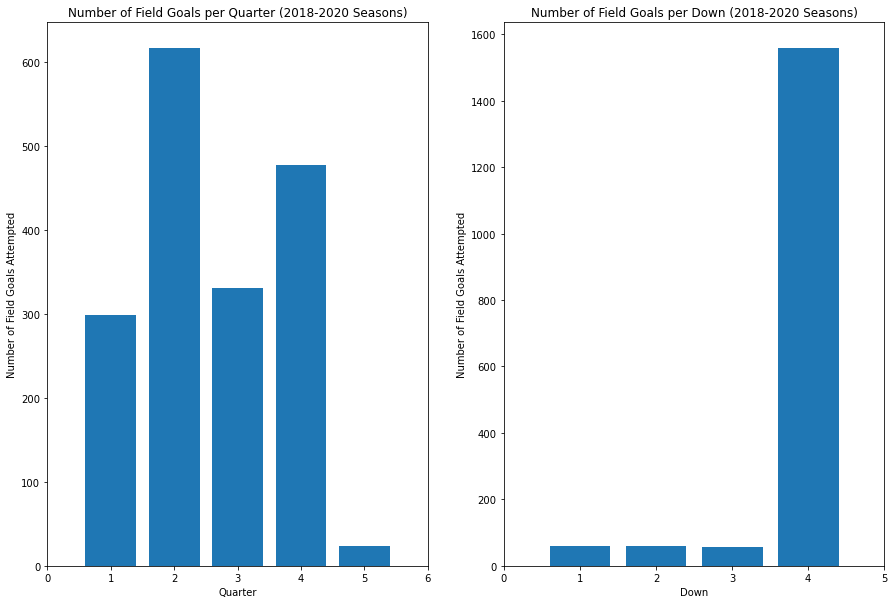

In [8]:
plt.figure(figsize=(15,10))

# Field Goals per Quarter
plt.subplot(1,2,1)
plt.bar(fg_df_by_quarter.quarter, fg_df_by_quarter.playId)
plt.title('Number of Field Goals per Quarter (2018-2020 Seasons)')
plt.xlabel('Quarter')
plt.ylabel('Number of Field Goals Attempted')
plt.xlim(0, 6)


# Field Goals per Down
plt.subplot(1,2,2)
plt.bar(fg_df_by_down.down, fg_df_by_down.playId)
plt.title('Number of Field Goals per Down (2018-2020 Seasons)')
plt.xlabel('Down')
plt.ylabel('Number of Field Goals Attempted')
plt.xlim(0, 5)
plt.show()


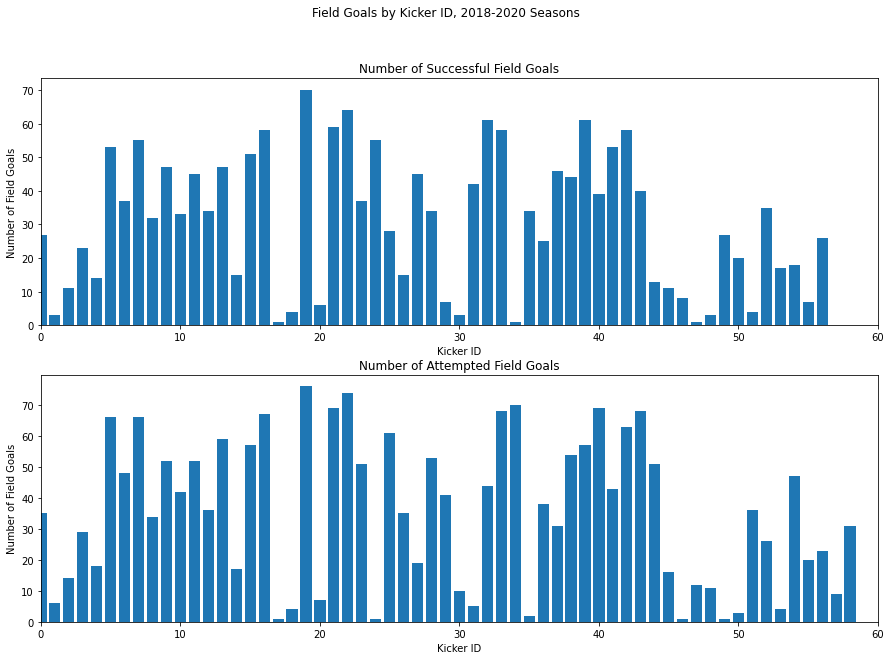

In [9]:
# Eventually refactor to viewing FG completion percentage
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.bar(np.arange(len(fg_success_by_kicker.kickerId)), fg_success_by_kicker.playId)
plt.title('Number of Successful Field Goals')
plt.xlabel('Kicker ID')
plt.ylabel('Number of Field Goals')
plt.xlim(0, 60)


plt.subplot(2,1,2)
plt.bar(np.arange(len(fg_total_by_kicker.kickerId)), fg_total_by_kicker.playId)
plt.title('Number of Attempted Field Goals')
plt.xlabel('Kicker ID')
plt.xlim(0, 60)
plt.ylabel('Number of Field Goals')

plt.suptitle('Field Goals by Kicker ID, 2018-2020 Seasons')
plt.show()


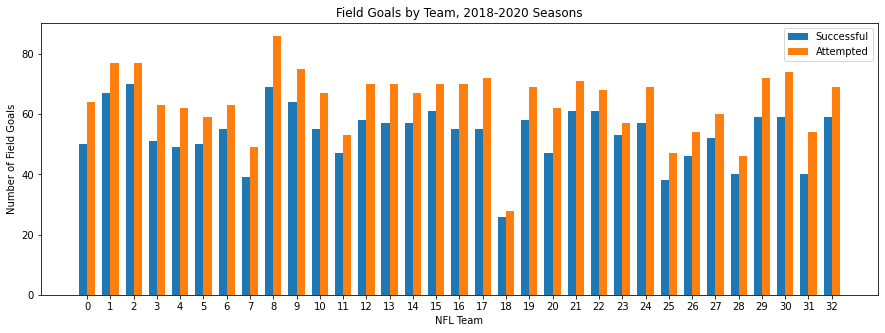

In [10]:
# Eventually refactor to viewing FG completion percentage

x = np.arange(len(fg_success_by_team.possessionTeam))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))

rects1 = ax.bar(x - width/2, fg_success_by_team.playId, width, label='Successful')
rects2 = ax.bar(x + width/2, fg_total_by_team.playId, width, label='Attempted')

ax.set_ylabel('Number of Field Goals')
ax.set_xlabel('NFL Team')
ax.set_title('Field Goals by Team, 2018-2020 Seasons')
ax.set_xticks(x)

ax.legend()

plt.show()

##### PATs

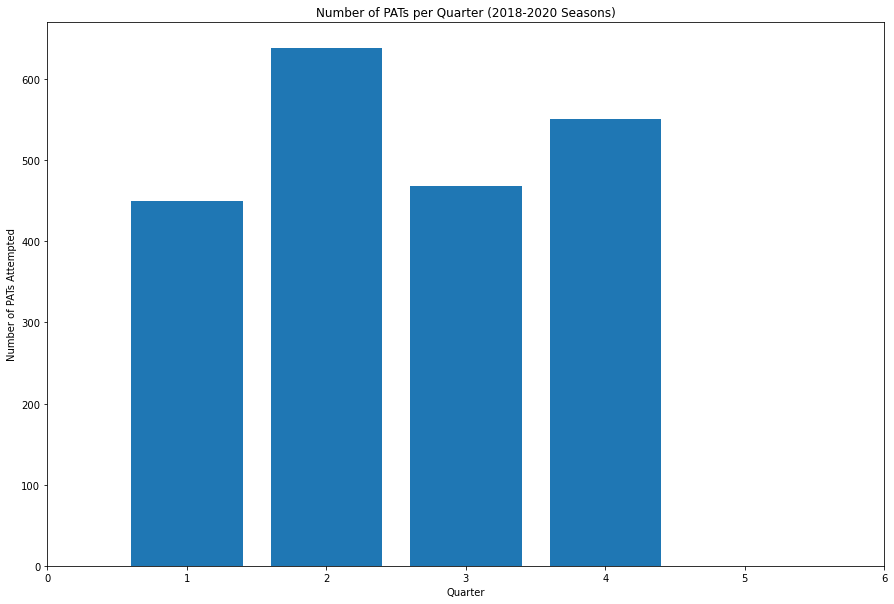

In [11]:
# PATs per Quarter
plt.figure(figsize=(15,10))

plt.bar(pat_df_by_quarter.quarter, pat_df_by_quarter.playId)
plt.title('Number of PATs per Quarter (2018-2020 Seasons)')
plt.xlabel('Quarter')
plt.ylabel('Number of PATs Attempted')
plt.xlim(0, 6)

plt.show()

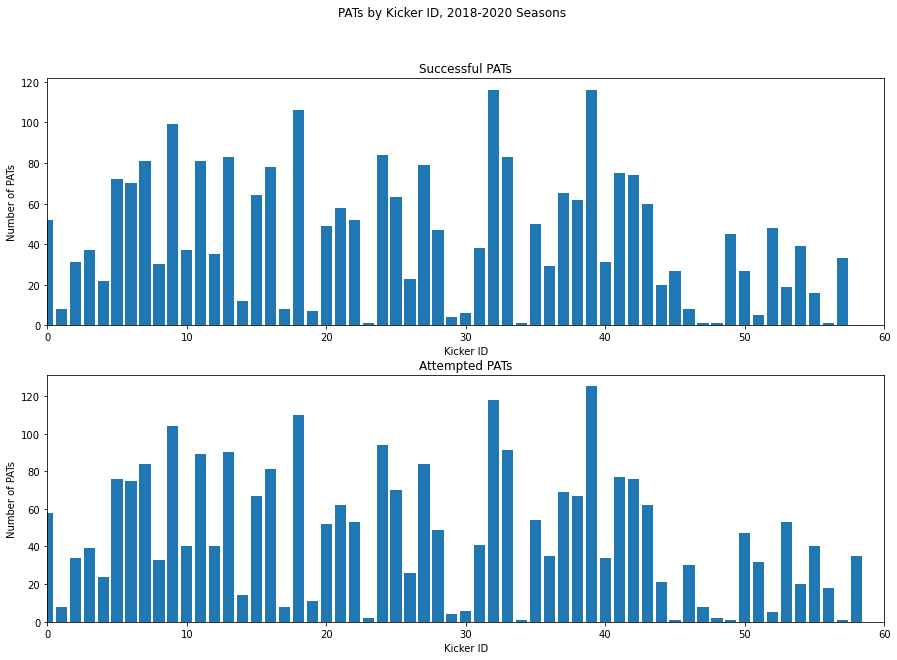

In [12]:
# Eventually refactor to viewing PAT completion percentage
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.bar(np.arange(len(pat_success_by_kicker.kickerId)), pat_success_by_kicker.playId)
plt.title('Successful PATs')
plt.xlabel('Kicker ID')
plt.ylabel('Number of PATs')
plt.xlim(0, 60)


plt.subplot(2,1,2)
plt.bar(np.arange(len(pat_total_by_kicker.kickerId)), pat_total_by_kicker.playId)
plt.title('Attempted PATs')
plt.xlabel('Kicker ID')
plt.xlim(0, 60)
plt.ylabel('Number of PATs')

plt.suptitle('PATs by Kicker ID, 2018-2020 Seasons')
plt.show()


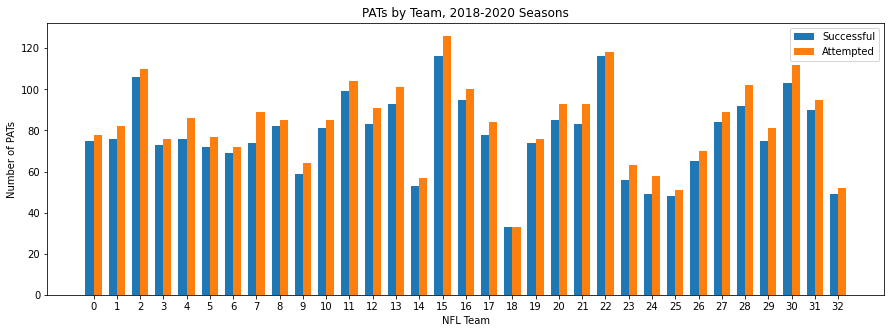

In [13]:
# plt.figure(figsize=(15, 5))

# plt.plot(pat_success_by_team.possessionTeam, pat_success_by_team.playId, label='Number of Successful PATs')
# plt.xlabel('Team')
# plt.ylabel('Number of PATs')

# plt.plot(pat_total_by_team.possessionTeam, pat_total_by_team.playId, label='Number of Attempted PATs')
# plt.xlabel('Team')
# plt.ylabel('Number of PATs')

# plt.legend()
# plt.suptitle('PATs by Team, 2018-2020 Seasons')
# plt.show()

# Eventually refactor to viewing FG completion percentage

x = np.arange(len(pat_success_by_team.possessionTeam))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))

rects1 = ax.bar(x - width/2, pat_success_by_team.playId, width, label='Successful')
rects2 = ax.bar(x + width/2, pat_total_by_team.playId, width, label='Attempted')

ax.set_ylabel('Number of PATs')
ax.set_xlabel('NFL Team')
ax.set_title('PATs by Team, 2018-2020 Seasons')
ax.set_xticks(x)

ax.legend()

plt.show()

### Overview of Tracking Data for NFL Seasons 2018-2020

In [14]:
print('Dataframe: 2018 Season')
tracking_2018_df.head()

Dataframe: 2018 Season


time      x      y     s     a   dis       o     dir  \
0  2018-12-30T21:25:32.200  41.32  29.45  4.36  1.33  0.43  130.42  128.44   
1  2018-12-30T21:25:32.300  41.68  29.17  4.59  1.24  0.45  128.59  127.81   
2  2018-12-30T21:25:32.400  42.05  28.88  4.74  0.99  0.47  124.47  128.15   
3  2018-12-30T21:25:32.500  42.43  28.59  4.87  0.71  0.48  126.02  127.35   
4  2018-12-30T21:25:32.600  42.84  28.31  4.96  0.79  0.50  131.71  124.75   

  event    nflId    displayName  jerseyNumber position  team  frameId  \
0  None  39470.0  Justin Tucker           9.0        K  home        1   
1  None  39470.0  Justin Tucker           9.0        K  home        2   
2  None  39470.0  Justin Tucker           9.0        K  home        3   
3  None  39470.0  Justin Tucker           9.0        K  home        4   
4  None  39470.0  Justin Tucker           9.0        K  home        5   

       gameId  playId playDirection  
0  2018123000      36         right  
1  2018123000      36         right  
2  2018123000      36         right  
3  2018123000      36         right  
4  2018123000      36         right

In [15]:
print('Dataframe: 2019 Season')
tracking_2019_df.head()

Dataframe: 2019 Season


time      x      y     s     a   dis       o     dir  \
0  2019-12-29T21:25:27.400  68.39  20.20  0.16  0.31  0.02  320.08  322.40   
1  2019-12-29T21:25:27.500  68.38  20.21  0.16  0.28  0.02  321.66  309.87   
2  2019-12-29T21:25:27.600  68.36  20.23  0.20  0.25  0.02  320.67  301.01   
3  2019-12-29T21:25:27.700  68.34  20.25  0.27  0.20  0.03  303.02  311.86   
4  2019-12-29T21:25:27.800  68.33  20.26  0.20  0.06  0.01  297.33  308.72   

  event    nflId     displayName  jerseyNumber position  team  frameId  \
0  None  36060.0  Anthony Levine          41.0       DB  home        1   
1  None  36060.0  Anthony Levine          41.0       DB  home        2   
2  None  36060.0  Anthony Levine          41.0       DB  home        3   
3  None  36060.0  Anthony Levine          41.0       DB  home        4   
4  None  36060.0  Anthony Levine          41.0       DB  home        5   

       gameId  playId playDirection  
0  2019122900      36         right  
1  2019122900      36         right  
2  2019122900      36         right  
3  2019122900      36         right  
4  2019122900      36         right

In [16]:
print('Dataframe: 2020 Season')
tracking_2020_df.head()

Dataframe: 2020 Season


time      x      y     s     a   dis       o     dir  \
0  2021-01-03T18:03:02.200  61.21  46.77  0.08  0.13  0.01  186.21  144.73   
1  2021-01-03T18:03:02.300  61.22  46.77  0.11  0.19  0.01  184.87  126.09   
2  2021-01-03T18:03:02.400  61.23  46.76  0.10  0.18  0.01  183.38  108.95   
3  2021-01-03T18:03:02.500  61.24  46.76  0.11  0.22  0.01  180.24   91.57   
4  2021-01-03T18:03:02.600  61.25  46.76  0.05  0.20  0.01  172.44  119.91   

  event    nflId   displayName  jerseyNumber position  team  frameId  \
0  None  42901.0  Dean Marlowe          31.0       SS  home        1   
1  None  42901.0  Dean Marlowe          31.0       SS  home        2   
2  None  42901.0  Dean Marlowe          31.0       SS  home        3   
3  None  42901.0  Dean Marlowe          31.0       SS  home        4   
4  None  42901.0  Dean Marlowe          31.0       SS  home        5   

       gameId  playId playDirection  
0  2021010300      40          left  
1  2021010300      40          left  
2  2021010300      40          left  
3  2021010300      40          left  
4  2021010300      40          left

## Wrangle Data

In [17]:
# fg_df has 2657 records

# The predicted responses should follow the categories found in `specialTeamsResult`. 
# Ultimately, this notebook will attempt to predict scenarios where `specialTeamsResult` will be `Kick Attempt Good`.

fg_train.specialTeamsResult.unique()

array(['Kick Attempt Good', 'Kick Attempt No Good',
       'Blocked Kick Attempt', 'Non-Special Teams Result', 'Downed',
       'Out of Bounds'], dtype=object)

In [18]:
# Combining season tracking data for holistic view of potential features that impact the success of the FG/PAT

season_tracking_df = pd.concat([tracking_2018_df, tracking_2019_df, tracking_2020_df])

In [19]:
# Reducing the season tracking data to the initial position for Field Goal plays
fg_initial_position = season_tracking_df[season_tracking_df.gameId.isin(fg_df.gameId) & 
                                         (season_tracking_df.frameId == 1) & 
                                         (season_tracking_df.position == 'K')]

# Reducing the season tracking data to the initial position for PAT plays
pat_initial_position = season_tracking_df[season_tracking_df.gameId.isin(pat_df.gameId) & 
                                         (season_tracking_df.frameId == 1) & 
                                         (season_tracking_df.position == 'K')]

In [20]:
fg_num_feats = ['yardsToGo', 'kickLength', 'preSnapHomeScore', 'preSnapVisitorScore', 'playResult', 'absoluteYardlineNumber']

fg_cat_feats = ['quarter', 'down', 'kickerId']

In [21]:
# pat_df has 3488 records

# The predicted responses should follow the categories found in `specialTeamsResult`. 
# Ultimately, this notebook will attempt to predict scenarios where `specialTeamsResult` will be `Kick Attempt Good`.

pat_train.specialTeamsResult.unique()

array(['Kick Attempt Good', 'Kick Attempt No Good',
       'Non-Special Teams Result', 'Blocked Kick Attempt'], dtype=object)

### Feature Engineering

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, fg_num_feats),
])

features = ['yardsToGo', 'kickLength', 'preSnapHomeScore', 'preSnapVisitorScore', 'playResult', 'absoluteYardlineNumber', 'quarter', 'down', 'kickerId']

In [23]:
fg_prepared = fg_train[features]
fg_features = full_pipeline.fit_transform(fg_prepared)
fg_features

array([[-0.13686735,  0.00512985, -0.46012882,  0.63844149,  0.32279586,
         0.93295302],
       [ 1.74628957, -0.39394396,  1.1170952 ,  0.53319027, -1.559073  ,
         1.05942184],
       [ 1.53704991,  0.        , -0.46012882, -0.41407066, -1.559073  ,
        -1.12216525],
       ...,
       [ 0.49085162,  1.00281439,  1.22224347,  0.95419513,  0.32279586,
         0.61678098],
       [ 0.28161196,  1.30211976,  0.06561252,  0.21743663,  0.32279586,
         0.52192937],
       [ 0.07237231,  0.00512985, -1.1961667 , -1.15082916,  0.32279586,
         0.93295302]])

### Response Engineering

In [24]:
# fg_df
fg_labels = pd.get_dummies(fg_train, columns=['specialTeamsResult']).rename(columns={'specialTeamsResult_Kick Attempt Good': 'fg_attempt_good'})
fg_response = fg_labels.fg_attempt_good

# pat_df
pat_labels = pd.get_dummies(pat_train, columns=['specialTeamsResult']).rename(columns={'specialTeamsResult_Kick Attempt Good': 'pat_attempt_good'})
pat_response = pat_labels.pat_attempt_good

## Model Data

In [25]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs', random_state=42)
log_reg.fit(fg_features, fg_response)

LogisticRegression(random_state=42)

In [26]:
log_reg.coef_

array([[-0.07448517, -0.52870447, -0.0215567 ,  0.06549723,  3.40895775,
        -0.14468286]])

In [27]:
log_reg.intercept_

array([2.88309073])

In [28]:
fg_prepared_preds = fg_test[features]
fg_predict = full_pipeline.transform(fg_prepared_preds)

print('Predictions:', log_reg.predict(fg_predict))

Predictions: [1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 0 1 1 0 1 1

In [29]:
fg_labels = pd.get_dummies(fg_test, columns=['specialTeamsResult']).rename(columns={'specialTeamsResult_Kick Attempt Good': 'fg_attempt_good'})
fg_labels = fg_labels.fg_attempt_good
print('Labels:', list(fg_labels))

Labels: [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1

In [30]:
from sklearn.metrics import accuracy_score

print("accuracy score: ", accuracy_score(fg_labels, log_reg.predict(fg_predict)))

accuracy score:  0.9887218045112782


## Solution

This is the solution, tbd.